In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import scipy
import corner
import pymc3 as pm
import seaborn as sns
import os
import time

import theano
import theano.tensor as T
from theano.ifelse import ifelse

import sys
sys.path.append("../theano_ops")
sys.path.append("../codebase")
from data_preprocessing_ogle import process_data
from plotting_utils import plot_data
from theano_ops.celerite.factor import FactorOp
from theano_ops.celerite.solve import SolveOp
from theano_ops.celerite import terms
from theano_ops.celerite.celerite import log_likelihood

from scipy.special import gamma
from scipy.stats import invgamma
from scipy.optimize import fsolve
mpl.rc('text', usetex=False)

import celerite
from celerite import terms

%matplotlib inline

In [2]:
events = [] # event names
lightcurves = [] # data for each event
 
i = 0
n_events = 1
for entry in os.scandir('/home/star/fb90/data/OGLE_ews/2017/'):
    if entry.is_dir() and (i < n_events):
        events.append(entry.name)
        photometry = np.genfromtxt(entry.path + '/phot.dat', usecols=(0,1,2))
        lightcurves.append(photometry)
        i = i + 1
        
print("Loaded events:", events)

Loaded events: ['blg-0001']


Median spacing between data points in hrs: 1.038000002503395
Minimum spacing between data points in hrs: 0.04968000948429108


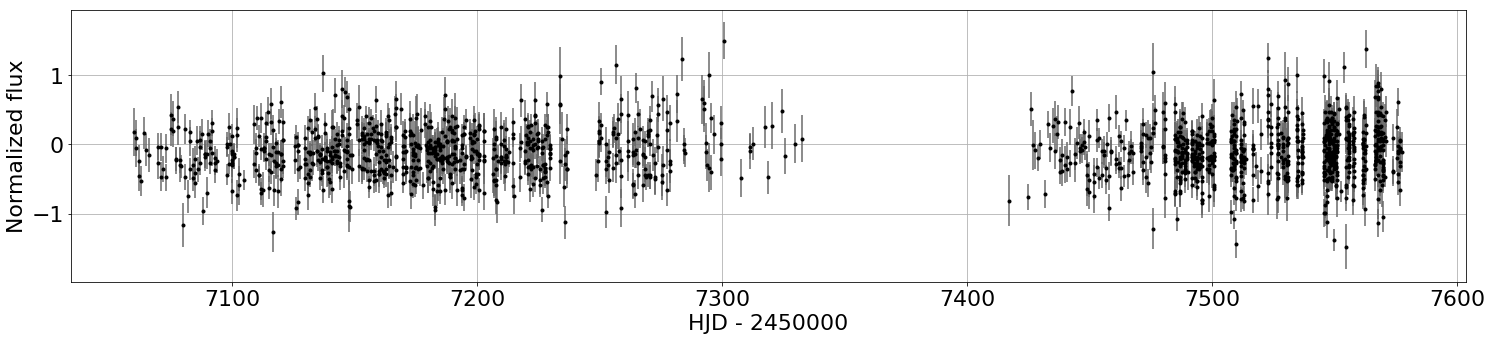

In [11]:
limits = [1700, 1900, 1900, 1700, 2500, 2100, 2600]

for event_index, lightcurve in enumerate(lightcurves):
    # Pre process the data
    t, F, sigF = process_data(lightcurve[:, 0], lightcurve[:, 1], 
        lightcurve[:, 2], standardize=True)
    
    t = t[:limits[event_index]]
    F = F[:limits[event_index]]
    sigF = sigF[:limits[event_index]]
    
    # Set up GP model
    kernel_celerite = terms.Matern32Term(log_sigma=np.log(0.5), log_rho=np.log(2.))
    gp_celerite = celerite.GP(kernel_celerite)

    fig, ax = plt.subplots(figsize=(25, 5))
    plot_data(ax, t, F, sigF)
                           
    # Grid of parameters in (ln_sigma, ln_rho) subspace
    ln_sigma_grid, ln_rho_grid = np.meshgrid(np.linspace(np.median(np.diff(t)), 0.2*(t[-1] - t[0]), 1000), np.linspace(-5, 5, 100))

    for i in range(100):
        for j in range(1000):
            gp_celerite.set_parameter_vector((ln_sigma_grid[i,j], ln_rho_grid[i,j]))
            gp_celerite.compute(t, sigF)
            likelihood_values[i, j] = gp_celerite.log_likelihood(F)  
    
#     ax.set_xlim(7100, 7102)
    print("Median spacing between data points in hrs:", np.median(np.diff(t))*24)
    print("Minimum spacing between data points in hrs:", np.min(np.diff(t))*24)

Text(0, 0.5, 'ln_rho')

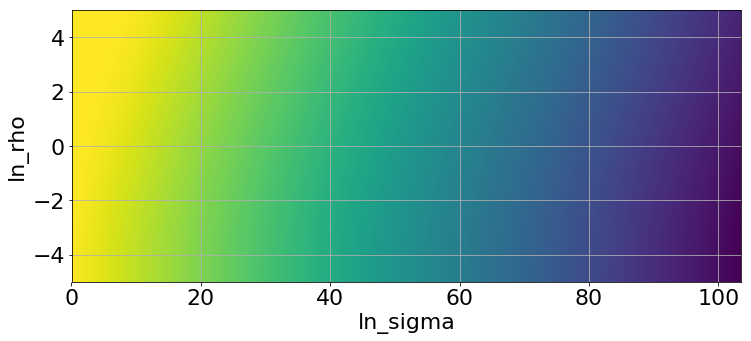

In [12]:
fig, ax = plt.subplots(figsize=(12,5))

colormap = ax.pcolormesh(ln_sigma_grid, ln_rho_grid, likelihood_values)

ax.grid()
ax.set_xlabel('ln_sigma')
ax.set_ylabel('ln_rho')

# fig.colorbar(colormap, cax=cbar, label='log likelihood')